In [1]:
import torch
import torch.nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
from sklearn_pandas import DataFrameMapper 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

from sksurv.ensemble import RandomSurvivalForest

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

import torchtuples as tt

from auton_survival.models.dsm import DeepSurvivalMachines

from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [2]:
# # Import Data
# flchain = pd.read_csv("resources/other_data/FLCHAIN.csv")
# nwtco = pd.read_csv("resources/other_data/NWTCO.csv")
# whas = pd.read_excel("resources/other_data/whas.xlsx")
# gbsg = pd.read_csv("resources/other_data/gbsg.csv")
# metabric = pd.read_csv("resources/other_data/METABRIC_RNA_Mutation.csv" , low_memory = False)
support = pd.read_csv("resources/other_data/support2.csv" , low_memory = False)

In [3]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.2 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

___________________
## **SUPPORT**

In [4]:
df_train , df_test , df_val = train_test_splitter(support)
y_train , y_test , y_val = df_train[['d.time' , 'death']] , df_test[['d.time' , 'death']] , df_val[['d.time' , 'death']]

In [5]:
numeric_preprocessing = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('imputing' , SimpleImputer())
])

categorical_preprocessing = Pipeline(steps=[
    ('encoding', OneHotEncoder()),
])

numeric_features = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 'temp',
             'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun',
             'urine', 'adlp', 'adls']

categorical_features = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']

preprocessing = ColumnTransformer(transformers=[
    ('numeric', numeric_preprocessing, numeric_features),
    ('categorical', categorical_preprocessing, categorical_features),
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing)
])

_df_train = pipeline.fit_transform(df_train)

#### **Non-Param**

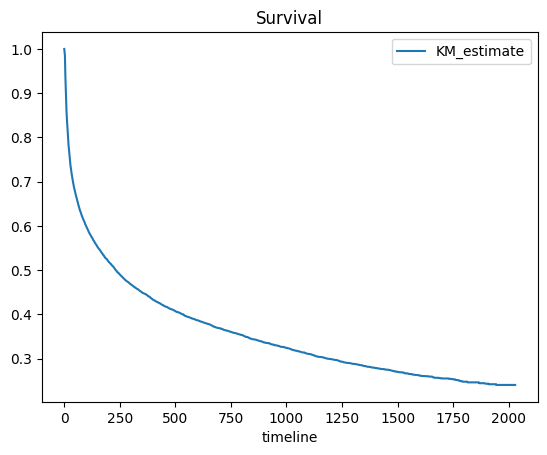

In [6]:
kmf = KaplanMeierFitter()

T = support['d.time']
E = support['death']

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot()
plt.title('Survival');

<Axes: xlabel='timeline'>

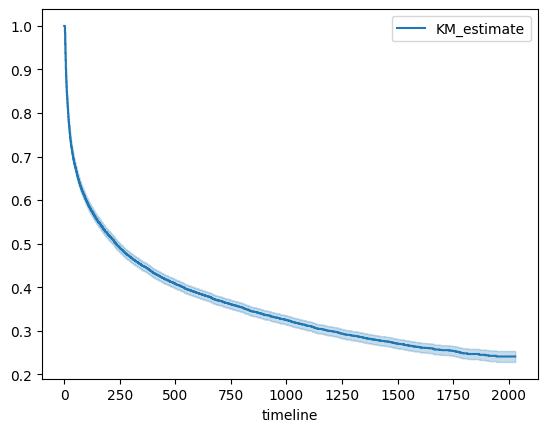

In [7]:
kmf.plot_survival_function()

<Axes: xlabel='timeline'>

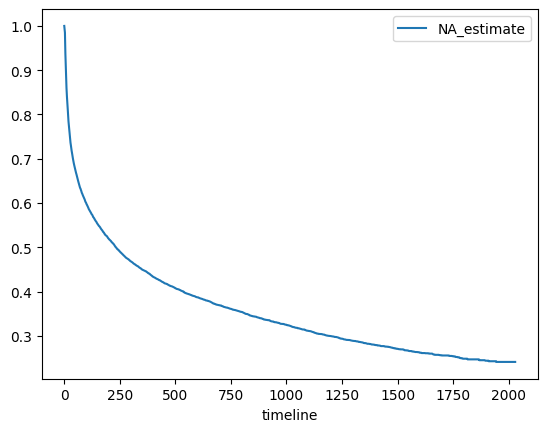

In [8]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
# print(naf.cumulative_hazard_.head())
# naf.plot_cumulative_hazard()
np.exp(-naf.cumulative_hazard_).plot()
# naf.plot_survival_function()

#### **Semi-Param**

In [9]:
cph = CoxPHFitter(penalizer=0.01) # penalizer added to deal with convergence problems

_df = pd.concat([pd.DataFrame(_df_train) , y_train.reset_index().drop('index' , axis = 1)] , axis = 1)

cph.fit(pd.DataFrame(_df), duration_col='d.time', event_col='death')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5827 total observations, 1869 right-censored observations>
             duration col = 'd.time'
                event col = 'death'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5827
number of events observed = 3958
   partial log-likelihood = -31505.80
         time fit was run = 2023-07-08 16:26:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0           0.24       1.27       0.02             0.20             0.28                 1.23                 1.32
1           0.13       1.14       0.02             0.10             0.17                 1.10                 1.19
2          -0.09       0.91       0.02            -0.13            -0.06                 0.88                 0.94
3           0.01       1.01       0.02            -0.02             0.04                 0.98                 1.04
4           0.07       1.07       0.02             0.03             0.10                 1.03                 1.11
5           0.02       1.02       0.02            -0.01             0.06                 0.99                 1.06
6          -0.03       0.97       0.02            -0.07             0.00                 0.93                 1.00
7          -0.02       0.98       0.02            -0.06             0.02                 0.94                 1.02
8          -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
9           0.12       1.12       0.02             0.08             0.15                 1.08                 1.16
10          0.06       1.06       0.02             0.03             0.10                 1.03                 1.10
11         -0.01       0.99       0.02            -0.04             0.02                 0.96                 1.02
12         -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
13         -0.01       0.99       0.02            -0.06             0.03                 0.94                 1.03
14         -0.06       0.94       0.03            -0.11            -0.01                 0.89                 0.99
15          0.04       1.04       0.02            -0.01             0.08                 0.99                 1.09
16          0.06       1.06       0.02             0.01             0.11                 1.01                 1.11
17          0.14       1.15       0.02             0.10             0.18                 1.10                 1.19
18         -0.06       0.94       0.19            -0.42             0.31                 0.65                 1.36
19          0.06       1.06       0.19            -0.31             0.42                 0.73                 1.53
20         -0.17       0.84       0.20            -0.57             0.22                 0.57                 1.25
21         -0.26       0.77       0.21            -0.68             0.16                 0.51                 1.17
22         -0.31       0.74       0.22            -0.73             0.12                 0.48                 1.12
23          0.13       1.14       0.22            -0.30             0.56                 0.74                 1.76
24         -0.04       0.96       0.28            -0.58             0.51                 0.56                 1.66
25          0.49       1.63       0.38            -0.26             1.24                 0.77                 3.46
26          0.20       1.22       0.27            -0.34             0.74                 0.71                 2.09
27          0.65       1.91       0.21             0.24             1.05                 1.27                 2.87
28          0.03       1.03       0.21            -0.39             0.45                 0.68                 1.57
29   

<Axes: >

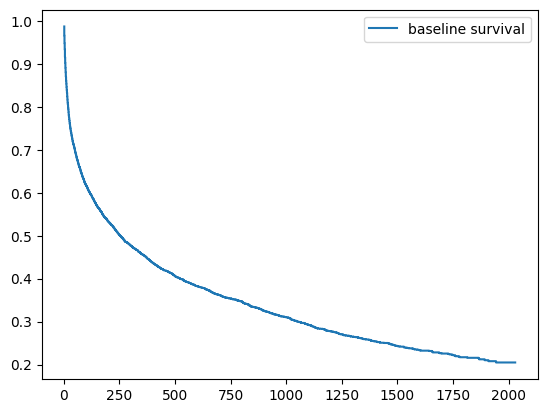

In [10]:
cph.baseline_survival_.plot(drawstyle = 'steps')
# cph.baseline_cumulative_hazard_.plot(drawstyle="steps")

#### **Param**

In [11]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
eps = 1e-8
# df_train_imp['futime'] = df_train_imp['futime'] + eps

aft.fit(_df, duration_col='d.time', event_col='death')

aft.print_summary(3)  # access the results using aft.summary

c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\lifelines\fitters\__init__.py:2086: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


<lifelines.WeibullAFTFitter: fitted with 5827 total observations, 1869 right-censored observations>
             duration col = 'd.time'
                event col = 'death'
   number of observations = 5827
number of events observed = 3958
           log-likelihood = -26932.377
         time fit was run = 2023-07-08 16:26:01 UTC

---
                    coef  exp(coef)     se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                           
lambda_ 0         -0.503      0.605        0.035           -0.572           -0.433                0.564                0.648
        1         -0.290      0.748        0.037           -0.363           -0.218                0.696                0.804
        2          0.187      1.206        0.034            0.121            0.253                1.128                1.288
        3         -0.015      0.986        0.030           -0.073            0.044                0.929                1.045
        4         -0.144      0.866        0.034           -0.212           -0.077                0.809                0.926
        5         -0.044      0.957        0.033           -0.109            0.021                0.897                1.021
        6          0.069      1.071        0.034            0.001            0.136                1.001                1.146
        7          0.035      1.035        0.038           -0.039            0.108                0.962                1.114
        8          0.013      1.013        0.044           -0.072            0.099                0.930                1.104
        9         -0.231      0.793        0.036           -0.301           -0.161                0.740                0.851
        10        -0.124      0.883        0.034           -0.191           -0.057                0.826                0.944
        11         0.031      1.032        0.032           -0.032            0.094                0.969                1.099
        12         0.019      1.020        0.038           -0.055            0.094                0.947                1.098
        13         0.025      1.025        0.045           -0.064            0.114                0.938                1.120
        14         0.122      1.130        0.053            0.019            0.226                1.019                1.253
        15        -0.076      0.927        0.048           -0.170            0.018                0.844                1.018
        16        -0.125      0.882        0.048           -0.218           -0.032                0.804                0.969
        17        -0.292      0.747        0.039           -0.368           -0.215                0.692                0.806
        18         0.082      1.085  2499905.919     -4899725.484      4899725.647                0.000                  inf
        19        -0.163      0.849  2504201.487     -4908144.887      4908144.561                0.000                  inf
        20         0.334      1.397          NaN              NaN              NaN                  NaN                  NaN
        21         0.509      1.664          NaN              NaN              NaN                  NaN                  NaN
        22         0.600      1.822          NaN              NaN              NaN                  NaN                  NaN
        23        -0.263      0.769          NaN              NaN              NaN                  NaN                  NaN
        24         0.032      1.033  2807561.545     -5502719.481      5502719.546                0.000                  inf
        25        -0.958      0.383 71995308.531   -141108212.736    141108210.819                0.000                  inf
        26        -0.495      0.610  2833207.257     -5552984.678      5552983.689                0.000                  inf
        27        -1.368      0.255     

<Axes: >

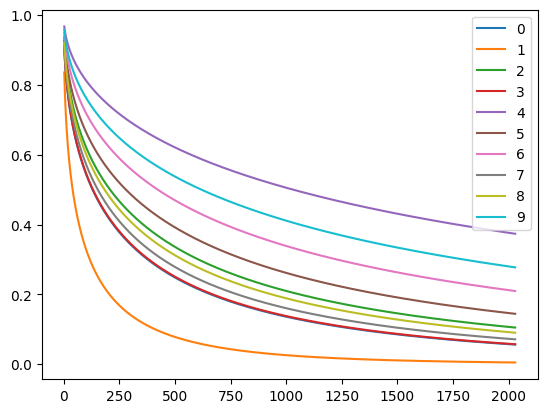

In [12]:
# X_test = pd.DataFrame(np.column_stack([x_test , y_test_dur , y_test_event]))

_df_test = pipeline.fit_transform(df_test)

_df = pd.concat([pd.DataFrame(_df_test) , y_test.reset_index().drop('index' , axis = 1)] , axis = 1)

aft.predict_survival_function(_df.iloc[:10]).plot()

#### **RSF**

In [13]:
y_train_rf = np.rec.array([y_train.iloc[:,1].astype('bool') , y_train.iloc[:,0]])
y_test_rf = np.rec.array([y_test.iloc[:,1].astype('bool') , y_test.iloc[:,0]])
y_val_rf = np.rec.array([y_val.iloc[:,1].astype('bool') , y_val.iloc[:,0]])

# X_val = pd.DataFrame(np.column_stack([x_val , y_val_dur , y_val_event]))

_df_val = pipeline.fit_transform(df_val)

In [14]:
_df_val.shape  , y_val_rf.shape

((1821, 46), (1821,))

In [15]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1234
)
rsf.fit(_df_val, y_val_rf)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=1234)

In [18]:
# Concordance
rsf.score(_df_test, y_test_rf)

0.6465267243204931

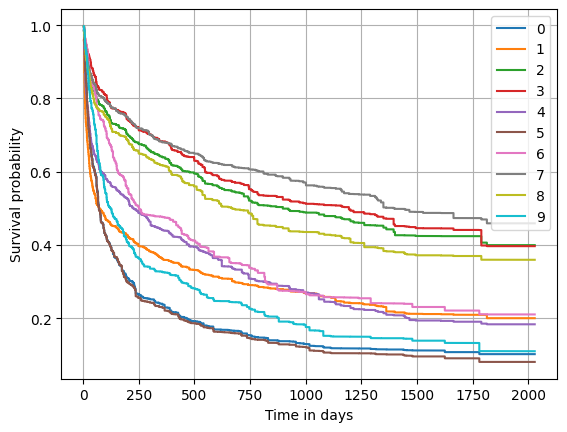

In [20]:
surv = rsf.predict_survival_function(_df_train[:10], return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

#### **PyCox**

#### **DSM**

In [25]:
from auton_survival.models.dsm import datasets
x, t, e = datasets.load_dataset('SUPPORT')

n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]

# x_train.shape , x_test.shape , x_val.shape , t_train.shape , t_test.shape , t_val.shape , e_train.shape , e_test.shape , e_val.shape 

_train = np.column_stack([x_train , t_train , e_train])
_test = np.column_stack([x_test , t_test , e_test])
_val = np.column_stack([x_val , t_val , e_val])

In [26]:
param_grid = {'k' : [3],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-4,],
              'layers' : [ [100], [100, 100] ]
             }
params = ParameterGrid(param_grid)

In [27]:
models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train, t_train, e_train, iters = 100, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(x_val, t_val, e_val), model]])
    print(f'nll loss {model.compute_nll(x_val, t_val, e_val)}')
best_model = min(models)
model = best_model[0][1]

100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


nll loss 1.7939714442789045


 39%|███▉      | 39/100 [00:04<00:07,  8.02it/s]


nll loss 1.7859570954609967


 75%|███████▌  | 75/100 [00:10<00:03,  6.90it/s]


nll loss 1.7838759153490618


 10%|█         | 10/100 [00:01<00:14,  6.25it/s]


nll loss 1.7794514313699228


 53%|█████▎    | 53/100 [00:08<00:07,  6.36it/s]


nll loss 1.782013749316964


  8%|▊         | 8/100 [00:01<00:18,  4.99it/s]


nll loss 1.783340197350646


100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


nll loss 1.7944466369761503


 39%|███▉      | 39/100 [00:05<00:08,  7.09it/s]


nll loss 1.7856956685390906


 59%|█████▉    | 59/100 [00:10<00:07,  5.73it/s]


nll loss 1.7781760136022329


 10%|█         | 10/100 [00:02<00:18,  4.76it/s]


nll loss 1.775734764301863


 48%|████▊     | 48/100 [00:09<00:10,  4.86it/s]


nll loss 1.778942612495985


 10%|█         | 10/100 [00:02<00:18,  4.89it/s]


nll loss 1.7763814852447173


100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


nll loss 1.7923756305299425


 23%|██▎       | 23/100 [00:04<00:14,  5.16it/s]


nll loss 1.7876869371352517


 80%|████████  | 80/100 [00:16<00:04,  4.85it/s]


nll loss 1.7763227789414509


 10%|█         | 10/100 [00:02<00:23,  3.89it/s]


nll loss 1.7830916906845162


 39%|███▉      | 39/100 [00:09<00:14,  4.15it/s]


nll loss 1.7862841434628307


 11%|█         | 11/100 [00:03<00:26,  3.31it/s]


nll loss 1.7764000585264363


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


nll loss 4.628322630601523


 91%|█████████ | 91/100 [00:10<00:01,  8.84it/s]


nll loss 4.52805384772593


 59%|█████▉    | 59/100 [00:07<00:05,  7.65it/s]


nll loss 4.522729356496078


 29%|██▉       | 29/100 [00:04<00:10,  6.99it/s]


nll loss 4.523705273752687


 30%|███       | 30/100 [00:04<00:11,  6.28it/s]


nll loss 4.528814703046878


  8%|▊         | 8/100 [00:01<00:16,  5.50it/s]


nll loss 4.524510499089848


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


nll loss 4.546069694563615


100%|██████████| 100/100 [00:11<00:00,  8.65it/s]


nll loss 4.6065009624186315


 89%|████████▉ | 89/100 [00:13<00:01,  6.67it/s]


nll loss 4.523183378164432


 24%|██▍       | 24/100 [00:03<00:11,  6.50it/s]


nll loss 4.529448423558165


 30%|███       | 30/100 [00:05<00:12,  5.49it/s]


nll loss 4.525966637773951


 12%|█▏        | 12/100 [00:02<00:16,  5.37it/s]


nll loss 4.509884394917261


100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


nll loss 4.583205440357314


 49%|████▉     | 49/100 [00:07<00:07,  6.69it/s]


nll loss 4.547659427544118


 78%|███████▊  | 78/100 [00:13<00:03,  5.63it/s]


nll loss 4.523246701294282


 18%|█▊        | 18/100 [00:03<00:17,  4.56it/s]


nll loss 4.5131649205645425


 26%|██▌       | 26/100 [00:05<00:15,  4.81it/s]


nll loss 4.517975806861253


  8%|▊         | 8/100 [00:01<00:21,  4.28it/s]

nll loss 4.521413639801891


In [29]:
horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e==1], horizons).tolist()

out_risk = model.predict_risk(x_test, times)
out_survival = model.predict_survival(x_test, times)

In [30]:
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.7562835523770887
Brier Score: 0.11190575040954488
ROC AUC  0.7640540765513223 

For 0.5 quantile,
TD Concordance Index: 0.699451012680695
Brier Score: 0.18408873855517074
ROC AUC  0.7188884201645223 

For 0.75 quantile,
TD Concordance Index: 0.6560254258387631
Brier Score: 0.22204813899098674
ROC AUC  0.7139274247289029 



In [47]:
x_train.shape , _df_train.shape , t_train.shape , y_train.iloc[:,1].to_numpy().shape

((6373, 44), (5827, 46), (6373,), (5827,))

In [48]:
models = []

# _t_train = y_train.iloc[:,0].to_numpy()
# _e_train = y_train.iloc[:,1].to_numpy() 

for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(_df_train, y_train.iloc[:,0].to_numpy() , y_train.iloc[:,1].to_numpy(), iters = 100, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(_df_val, y_val.iloc[:,0].to_numpy(), y_val.iloc[:,1].to_numpy()), model]])
    # print(f'nll loss {model.compute_nll(pd.DataFrame(_df_val), y_train.reset_index().drop('index' , axis = 1).iloc[:,1] , y_train.reset_index().drop('index' , axis = 1).iloc[:,0] )}')
best_model = min(models)
model = best_model[0][1]

  7%|▋         | 7/100 [00:01<00:22,  4.21it/s]


In [52]:
horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e==1], horizons).tolist()

out_risk = model.predict_risk(_df_test, times)
out_survival = model.predict_survival(_df_test, times)

In [54]:
cis = []
brs = []

et_train = np.array([(y_train.iloc[:,1].to_numpy()[i], y_train.iloc[:,0].to_numpy()[i]) for i in range(len(y_train.iloc[:,1].to_numpy()))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(y_test.iloc[:,1].to_numpy()[i], y_test.iloc[:,0].to_numpy()[i]) for i in range(len(y_test.iloc[:,1].to_numpy()))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(y_val.iloc[:,1].to_numpy()[i], y_val.iloc[:,0].to_numpy()[i]) for i in range(len(y_val.iloc[:,1].to_numpy()))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.7126765278023394
Brier Score: 0.1384713353656879
ROC AUC  0.720123912402773 

For 0.5 quantile,
TD Concordance Index: 0.6809627416379241
Brier Score: 0.2071746319740955
ROC AUC  0.7047056514585891 

For 0.75 quantile,
TD Concordance Index: 0.6284385173680594
Brier Score: 0.22876215245138107
ROC AUC  0.6676438428474475 



In [57]:
_df_train.shape, y_train.iloc[:,0].to_numpy().shape , y_train.iloc[:,1].to_numpy().shape

((5827, 46), (5827,), (5827,))

In [59]:
type(_df_train), type(y_train.iloc[:,0].to_numpy()) , type(y_train.iloc[:,1].to_numpy())

(numpy.ndarray, numpy.ndarray, numpy.ndarray)